Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [7]:
print('Using L2 Regularization for Logistic Model')
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf_l2_feature * tf.nn.l2_loss(weights)

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

print('Tensorflow Graph created')

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Using L2 Regularization for Logistic Model
Tensorflow Graph created
Initialized
Minibatch loss at step 0: 21.191835
Minibatch accuracy: 5.5%
Validation accuracy: 7.5%
Minibatch loss at step 500: 2.362669
Minibatch accuracy: 81.2%
Validation accuracy: 76.4%
Minibatch loss at step 1000: 1.800544
Minibatch accuracy: 76.6%
Validation accuracy: 78.4%
Minibatch loss at step 1500: 0.934974
Minibatch accuracy: 84.4%
Validation accuracy: 79.6%
Minibatch loss at step 2000: 0.803659
Minibatch accuracy: 89.8%
Validation accuracy: 80.5%
Minibatch loss at step 2500: 0.829100
Minibatch accuracy: 79.7%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 0.753053
Minibatch accuracy: 82.0%
Validation accuracy: 81.6%
Test accuracy: 88.9%


In [8]:
print('Tunning the L2 Regularization constant')

num_steps = 3001
l2_constant_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []
max_accuracy, best_l2_constant = 0, 0

for l2_constant in l2_constant_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: l2_constant}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        if test_accuracy == max(max_accuracy, test_accuracy):
            max_accuracy = test_accuracy
            best_l2_constant = l2_constant
        accuracy_values.append(test_accuracy)
        print('L2 Regularization constant of %f performed with %.2f%% accuracy' % (l2_constant, accuracy_values[-1]))

Tunning the L2 Regularization constant
L2 Regularization constant of 0.000100 performed with 86.78% accuracy
L2 Regularization constant of 0.000126 performed with 86.63% accuracy
L2 Regularization constant of 0.000158 performed with 87.20% accuracy
L2 Regularization constant of 0.000200 performed with 87.50% accuracy
L2 Regularization constant of 0.000251 performed with 87.37% accuracy
L2 Regularization constant of 0.000316 performed with 87.47% accuracy
L2 Regularization constant of 0.000398 performed with 88.07% accuracy
L2 Regularization constant of 0.000501 performed with 88.19% accuracy
L2 Regularization constant of 0.000631 performed with 88.68% accuracy
L2 Regularization constant of 0.000794 performed with 88.75% accuracy
L2 Regularization constant of 0.001000 performed with 88.92% accuracy
L2 Regularization constant of 0.001259 performed with 88.95% accuracy
L2 Regularization constant of 0.001585 performed with 89.22% accuracy
L2 Regularization constant of 0.001995 performed wi

Plot the L2 Regularization loss for our Test


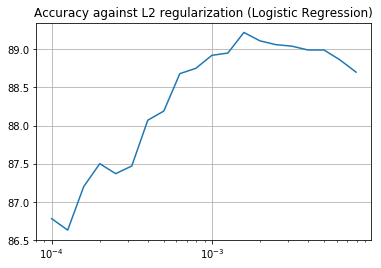

Maximum accuracy is 89.22% with L2 Regularization constant of 0.001585


In [9]:
print('Plot the L2 Regularization loss for our Test')
plt.semilogx(l2_constant_values, accuracy_values)
plt.grid(True)
plt.title('Accuracy against L2 regularization (Logistic Regression)')
plt.show()
print('Maximum accuracy is %.2f%% with L2 Regularization constant of %f' % (max_accuracy, best_l2_constant))

In [10]:
print('Using L2 Regularization for Neural Network Model (1 Hidden Layer)')
batch_size = 128
num_hidden_nodes = 1024

# Buildig the Network
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)

    # Variables.
    layer1_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    layer1_biases = tf.Variable(tf.zeros([num_hidden_nodes]))
    layer2_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    layer2_biases = tf.Variable(tf.zeros([num_labels]))    

    # Training computation.
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, layer1_weights) + layer1_biases)
    logits = tf.matmul(hidden_layer, layer2_weights) + layer2_biases
    loss = tf.reduce_mean( \
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    tf_l2_feature * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden_layer_valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, layer1_weights) + layer1_biases)
    valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_layer_valid_prediction, layer2_weights) + layer2_biases)
    hidden_layer_test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, layer1_weights) + layer1_biases)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_layer_test_prediction, layer2_weights) + layer2_biases)

print('Tensorflow Graph created')

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Using L2 Regularization for Neural Network Model (1 Layer)
Tensorflow Graph created
Initialized
Minibatch loss at step 0: 645.319702
Minibatch accuracy: 10.2%
Validation accuracy: 31.8%
Minibatch loss at step 500: 196.499054
Minibatch accuracy: 84.4%
Validation accuracy: 77.5%
Minibatch loss at step 1000: 115.158943
Minibatch accuracy: 78.1%
Validation accuracy: 80.9%
Minibatch loss at step 1500: 68.722801
Minibatch accuracy: 87.5%
Validation accuracy: 83.5%
Minibatch loss at step 2000: 41.229263
Minibatch accuracy: 89.8%
Validation accuracy: 85.3%
Minibatch loss at step 2500: 25.131517
Minibatch accuracy: 88.3%
Validation accuracy: 86.1%
Minibatch loss at step 3000: 15.487769
Minibatch accuracy: 85.9%
Validation accuracy: 86.6%
Test accuracy: 92.9%


In [11]:
print('Tunning the L2 Regularization constant with 1 Hidden Layer')

num_steps = 3001
l2_constant_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []
max_accuracy, best_l2_constant = 0, 0

for l2_constant in l2_constant_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: l2_constant}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        if test_accuracy == max(max_accuracy, test_accuracy):
            max_accuracy = test_accuracy
            best_l2_constant = l2_constant
        accuracy_values.append(test_accuracy)
    print('Accuracy of %.2f%% for L2 parameter constant of %f' % (accuracy_values[-1], l2_constant))

Tunning the L2 Regularization constant
Accuracy of 89.87% for L2 parameter constant of 0.000100
Accuracy of 89.84% for L2 parameter constant of 0.000126
Accuracy of 90.38% for L2 parameter constant of 0.000158
Accuracy of 90.21% for L2 parameter constant of 0.000200
Accuracy of 90.71% for L2 parameter constant of 0.000251
Accuracy of 90.75% for L2 parameter constant of 0.000316
Accuracy of 91.00% for L2 parameter constant of 0.000398
Accuracy of 91.40% for L2 parameter constant of 0.000501
Accuracy of 92.39% for L2 parameter constant of 0.000631
Accuracy of 92.81% for L2 parameter constant of 0.000794
Accuracy of 93.03% for L2 parameter constant of 0.001000
Accuracy of 92.90% for L2 parameter constant of 0.001259
Accuracy of 93.31% for L2 parameter constant of 0.001585
Accuracy of 93.03% for L2 parameter constant of 0.001995
Accuracy of 92.78% for L2 parameter constant of 0.002512
Accuracy of 92.49% for L2 parameter constant of 0.003162
Accuracy of 92.02% for L2 parameter constant of 0

Plot the L2 Regularization loss for our Test


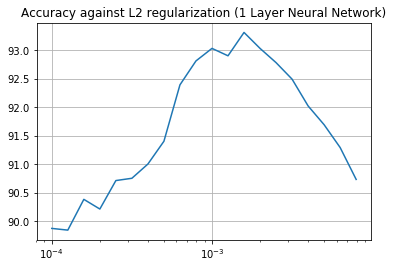

Maximum accuracy is 0.00% with L2 Regularization constant of 0.000000


In [14]:
print('Plot the L2 Regularization loss for our Test')
plt.semilogx(l2_constant_values, accuracy_values)
plt.grid(True)
plt.title('Accuracy against L2 regularization (1 Hidden Layer Neural Network)')
plt.show()
print('Maximum accuracy is %.2f%% with L2 Regularization constant of %f' % (max_accuracy, best_l2_constant))

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [15]:
print('Using L2 Regularization for Neural Network Model (1 Hidden Layer) with overfitting')
batch_size = 128
num_hidden_nodes = 1024

# Buildig the Network
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)

    # Variables.
    layer1_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    layer1_biases = tf.Variable(tf.zeros([num_hidden_nodes]))
    layer2_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    layer2_biases = tf.Variable(tf.zeros([num_labels]))    

    # Training computation.
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, layer1_weights) + layer1_biases)
    logits = tf.matmul(hidden_layer, layer2_weights) + layer2_biases
    loss = tf.reduce_mean( \
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    tf_l2_feature * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden_layer_valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, layer1_weights) + layer1_biases)
    valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_layer_valid_prediction, layer2_weights) + layer2_biases)
    hidden_layer_test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, layer1_weights) + layer1_biases)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_layer_test_prediction, layer2_weights) + layer2_biases)

print('Tensorflow Graph created')

num_steps = 101

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: best_l2_constant}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Using L2 Regularization for Neural Network Model (1 Layer) with overfitting
Tensorflow Graph created
Initialized
Minibatch loss at step 0: 415.654114
Minibatch accuracy: 11.7%
Validation accuracy: 32.1%
Minibatch loss at step 1: 1396.770386
Minibatch accuracy: 25.8%
Validation accuracy: 34.4%
Minibatch loss at step 2: 2438.612793
Minibatch accuracy: 36.7%
Validation accuracy: 31.0%
Minibatch loss at step 3: 867.941528
Minibatch accuracy: 23.4%
Validation accuracy: 47.4%
Minibatch loss at step 4: 668.226318
Minibatch accuracy: 50.0%
Validation accuracy: 54.2%
Minibatch loss at step 5: 466.870239
Minibatch accuracy: 55.5%
Validation accuracy: 66.0%
Minibatch loss at step 6: 247.263153
Minibatch accuracy: 65.6%
Validation accuracy: 70.0%
Minibatch loss at step 7: 170.861816
Minibatch accuracy: 64.8%
Validation accuracy: 63.8%
Minibatch loss at step 8: 306.140686
Minibatch accuracy: 60.9%
Validation accuracy: 66.8%
Minibatch loss at step 9: 203.198593
Minibatch accuracy: 70.3%
Validation a

Validation accuracy: 77.5%
Minibatch loss at step 90: 14.857161
Minibatch accuracy: 79.7%
Validation accuracy: 78.4%
Minibatch loss at step 91: 15.130486
Minibatch accuracy: 79.7%
Validation accuracy: 76.8%
Minibatch loss at step 92: 36.732830
Minibatch accuracy: 73.4%
Validation accuracy: 76.7%
Minibatch loss at step 93: 40.709412
Minibatch accuracy: 82.8%
Validation accuracy: 75.1%
Minibatch loss at step 94: 45.540543
Minibatch accuracy: 65.6%
Validation accuracy: 74.2%
Minibatch loss at step 95: 49.184685
Minibatch accuracy: 76.6%
Validation accuracy: 76.2%
Minibatch loss at step 96: 37.302441
Minibatch accuracy: 70.3%
Validation accuracy: 77.2%
Minibatch loss at step 97: 51.089226
Minibatch accuracy: 78.1%
Validation accuracy: 78.9%
Minibatch loss at step 98: 36.782379
Minibatch accuracy: 81.2%
Validation accuracy: 78.7%
Minibatch loss at step 99: 20.610994
Minibatch accuracy: 82.0%
Validation accuracy: 77.8%
Minibatch loss at step 100: 18.469290
Minibatch accuracy: 78.1%
Validatio

In [20]:
print('Tunning the L2 Regularization constant')

num_steps = 101
l2_constant_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []
max_accuracy, best_l2_constant = 0, 0

for l2_constant in l2_constant_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: l2_constant}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        if test_accuracy == max(max_accuracy, test_accuracy):
            max_accuracy = test_accuracy
            best_l2_constant = l2_constant
        accuracy_values.append(test_accuracy)
    print('Accuracy of %.2f%% for L2 parameter constant of %f' % (accuracy_values[-1], l2_constant))

Tunning the L2 Regularization constant
Accuracy of 86.46% for L2 parameter constant of 0.000100
Accuracy of 85.25% for L2 parameter constant of 0.000126
Accuracy of 85.60% for L2 parameter constant of 0.000158
Accuracy of 86.36% for L2 parameter constant of 0.000200
Accuracy of 84.82% for L2 parameter constant of 0.000251
Accuracy of 84.93% for L2 parameter constant of 0.000316
Accuracy of 85.31% for L2 parameter constant of 0.000398
Accuracy of 84.92% for L2 parameter constant of 0.000501
Accuracy of 86.15% for L2 parameter constant of 0.000631
Accuracy of 83.56% for L2 parameter constant of 0.000794
Accuracy of 84.98% for L2 parameter constant of 0.001000
Accuracy of 86.06% for L2 parameter constant of 0.001259
Accuracy of 86.83% for L2 parameter constant of 0.001585
Accuracy of 84.14% for L2 parameter constant of 0.001995
Accuracy of 85.69% for L2 parameter constant of 0.002512
Accuracy of 86.52% for L2 parameter constant of 0.003162
Accuracy of 87.04% for L2 parameter constant of 0

Plot the L2 Regularization loss for our Test


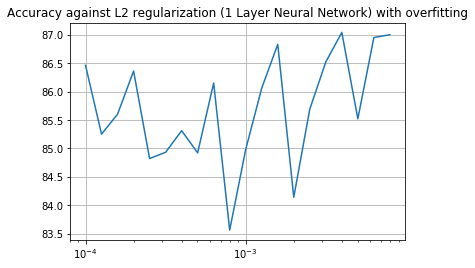

Maximum accuracy is 87.04% with L2 Regularization constant of 0.003981


In [22]:
print('Plot the L2 Regularization loss for our Test')
plt.semilogx(l2_constant_values, accuracy_values)
plt.grid(True)
plt.title('Accuracy against L2 regularization (1 Hidden Layer Neural Network) with overfitting')
plt.show()
print('Maximum accuracy is %.2f%% with L2 Regularization constant of %f' % (max_accuracy, best_l2_constant))

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [26]:
print('Using L2 Regularization for Neural Network Model (1 Hidden Layer) with Dropout')
batch_size = 128
num_hidden_nodes = 1024
dropout_rate = 0.5

# Buildig the Network
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)

    # Variables.
    layer1_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    layer1_biases = tf.Variable(tf.zeros([num_hidden_nodes]))
    layer2_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    layer2_biases = tf.Variable(tf.zeros([num_labels]))    

    # Training computation.
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, layer1_weights) + layer1_biases)
    hidden_layer_with_dropout = tf.nn.dropout(hidden_layer, dropout_rate)
    logits = tf.matmul(hidden_layer_with_dropout, layer2_weights) + layer2_biases
    loss = tf.reduce_mean( \
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    tf_l2_feature * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden_layer_valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, layer1_weights) + layer1_biases)
    valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_layer_valid_prediction, layer2_weights) + layer2_biases)
    hidden_layer_test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, layer1_weights) + layer1_biases)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_layer_test_prediction, layer2_weights) + layer2_biases)

print('Tensorflow Graph created')

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Using L2 Regularization for Neural Network Model (1 Layer) with Dropout
Tensorflow Graph created
Initialized
Minibatch loss at step 0: 810.623657
Minibatch accuracy: 11.7%
Validation accuracy: 38.8%
Minibatch loss at step 500: 208.655304
Minibatch accuracy: 74.2%
Validation accuracy: 79.7%
Minibatch loss at step 1000: 117.830223
Minibatch accuracy: 75.8%
Validation accuracy: 80.5%
Minibatch loss at step 1500: 69.159241
Minibatch accuracy: 79.7%
Validation accuracy: 81.0%
Minibatch loss at step 2000: 41.376431
Minibatch accuracy: 83.6%
Validation accuracy: 83.5%
Minibatch loss at step 2500: 25.264975
Minibatch accuracy: 79.7%
Validation accuracy: 84.6%
Minibatch loss at step 3000: 15.554621
Minibatch accuracy: 79.7%
Validation accuracy: 85.2%
Test accuracy: 91.8%


In [27]:
print('Tunning the L2 Regularization constant with Dropout')

l2_constant_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []
max_accuracy, best_l2_constant = 0, 0

for l2_constant in l2_constant_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: l2_constant}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        if test_accuracy == max(max_accuracy, test_accuracy):
            max_accuracy = test_accuracy
            best_l2_constant = l2_constant
        accuracy_values.append(test_accuracy)
    print('Accuracy of %.2f%% for L2 parameter constant of %f' % (accuracy_values[-1], l2_constant))

Tunning the L2 Regularization constant with Dropout
Accuracy of 87.92% for L2 parameter constant of 0.000100
Accuracy of 87.78% for L2 parameter constant of 0.000126
Accuracy of 88.01% for L2 parameter constant of 0.000158
Accuracy of 88.18% for L2 parameter constant of 0.000200
Accuracy of 88.95% for L2 parameter constant of 0.000251
Accuracy of 89.29% for L2 parameter constant of 0.000316
Accuracy of 89.05% for L2 parameter constant of 0.000398
Accuracy of 90.15% for L2 parameter constant of 0.000501
Accuracy of 91.22% for L2 parameter constant of 0.000631
Accuracy of 91.62% for L2 parameter constant of 0.000794
Accuracy of 91.86% for L2 parameter constant of 0.001000
Accuracy of 92.13% for L2 parameter constant of 0.001259
Accuracy of 92.08% for L2 parameter constant of 0.001585
Accuracy of 92.29% for L2 parameter constant of 0.001995
Accuracy of 92.12% for L2 parameter constant of 0.002512
Accuracy of 91.66% for L2 parameter constant of 0.003162
Accuracy of 91.24% for L2 parameter 

Plot the L2 Regularization loss for our Test


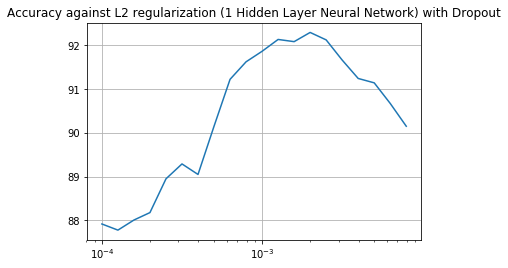

Maximum accuracy is 92.29% with L2 Regularization constant of 0.001995


In [28]:
print('Plot the L2 Regularization loss for our Test')
plt.semilogx(l2_constant_values, accuracy_values)
plt.grid(True)
plt.title('Accuracy against L2 regularization (1 Hidden Layer Neural Network) with Dropout')
plt.show()
print('Maximum accuracy is %.2f%% with L2 Regularization constant of %f' % (max_accuracy, best_l2_constant))

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [ ]:
print('Using L2 Regularization for Neural Network Model (2 Hidden Layer Network)')
batch_size = 128
num_first_hidden_nodes = 1024
num_last_hidden_nodes = 200
dropout_rate = 0.5

# Building the Network
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
        shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)
    # Global step for learning rate
    global_step = tf.Variable(0)

    # Variables.
    layer1_weights = tf.Variable( \
        tf.truncated_normal([image_size * image_size, num_first_hidden_nodes],
        stddev=np.sqrt(2.0 / (image_size * image_size))))
    layer1_biases = tf.Variable(tf.zeros([num_first_hidden_nodes]))
    layer2_weights = tf.Variable( \
        tf.truncated_normal([num_first_hidden_nodes, num_last_hidden_nodes], 
        stddev=np.sqrt(2.0 / num_first_hidden_nodes)))
    layer2_biases = tf.Variable(tf.zeros([num_last_hidden_nodes])) 
    last_layer_weights = tf.Variable( \
        tf.truncated_normal([num_last_hidden_nodes, num_labels], 
        stddev=np.sqrt(2.0 / num_labels)))
    last_layer_biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    first_hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, layer1_weights) + layer1_biases)
    last_hidden_layer = tf.nn.relu(tf.matmul(first_hidden_layer, layer2_weights) + layer2_biases)
    logits = tf.matmul(last_hidden_layer, last_layer_weights) + last_layer_biases
    
    loss = tf.reduce_mean( \
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
        tf_l2_feature * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) +  \
        tf.nn.l2_loss(last_layer_weights))

    # Learning Rate
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    first_hidden_layer_valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, layer1_weights) + layer1_biases)
    last_hidden_layer_valid_prediction = tf.nn.relu( \
        tf.matmul(first_hidden_layer_valid_prediction, layer2_weights) + layer2_biases)
    valid_prediction = tf.nn.softmax( \
        tf.matmul(last_hidden_layer_valid_prediction, last_layer_weights) + last_layer_biases)
    
    first_hidden_layer_test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, layer1_weights) + layer1_biases)
    last_hidden_layer_test_prediction = tf.nn.relu( \
        tf.matmul(first_hidden_layer_test_prediction, layer2_weights) + layer2_biases)
    test_prediction = tf.nn.softmax( \
        tf.matmul(last_hidden_layer_test_prediction, last_layer_weights) + last_layer_biases)

    
print('Tensorflow Graph created')

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Using L2 Regularization for Neural Network Model (2 Hidden Layer Network)
Tensorflow Graph created
Initialized
Minibatch loss at step 0: 4.411750
Minibatch accuracy: 7.0%
Validation accuracy: 27.7%
Minibatch loss at step 500: 1.104148
Minibatch accuracy: 88.3%
Validation accuracy: 85.7%
Minibatch loss at step 1000: 0.996774
Minibatch accuracy: 85.2%
Validation accuracy: 86.3%
Minibatch loss at step 1500: 0.603578
Minibatch accuracy: 91.4%
Validation accuracy: 87.4%
Minibatch loss at step 2000: 0.509534
Minibatch accuracy: 93.0%
Validation accuracy: 87.9%
Minibatch loss at step 2500: 0.548968
Minibatch accuracy: 89.8%
Validation accuracy: 88.0%


In [51]:
print('Tunning the L2 Regularization constant')

l2_constant_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []
max_accuracy, best_l2_constant = 0, 0

for l2_constant in l2_constant_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: l2_constant}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        if test_accuracy == max(max_accuracy, test_accuracy):
            max_accuracy = test_accuracy
            best_l2_constant = l2_constant
        accuracy_values.append(test_accuracy)
    print('Accuracy of %.2f%% for L2 parameter constant of %f' % (accuracy_values[-1], l2_constant))

Tunning the L2 Regularization constant
Accuracy of 93.52% for L2 parameter constant of 0.000100
Accuracy of 94.67% for L2 parameter constant of 0.000126
Accuracy of 94.19% for L2 parameter constant of 0.000158
Accuracy of 94.41% for L2 parameter constant of 0.000200
Accuracy of 94.10% for L2 parameter constant of 0.000251
Accuracy of 93.93% for L2 parameter constant of 0.000316
Accuracy of 94.35% for L2 parameter constant of 0.000398
Accuracy of 94.29% for L2 parameter constant of 0.000501
Accuracy of 94.16% for L2 parameter constant of 0.000631
Accuracy of 94.13% for L2 parameter constant of 0.000794
Accuracy of 94.13% for L2 parameter constant of 0.001000
Accuracy of 93.89% for L2 parameter constant of 0.001259
Accuracy of 93.40% for L2 parameter constant of 0.001585
Accuracy of 93.38% for L2 parameter constant of 0.001995
Accuracy of 92.96% for L2 parameter constant of 0.002512
Accuracy of 92.70% for L2 parameter constant of 0.003162
Accuracy of 92.13% for L2 parameter constant of 0

Plot the L2 Regularization loss for our Test


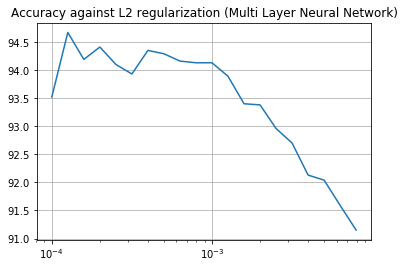

Maximum accuracy is 94.67% with L2 Regularization constant of 0.000126


In [52]:
print('Plot the L2 Regularization loss for our Test')
plt.semilogx(l2_constant_values, accuracy_values)
plt.grid(True)
plt.title('Accuracy against L2 regularization (Multi Layer Neural Network)')
plt.show()
print('Maximum accuracy is %.2f%% with L2 Regularization constant of %f' % (max_accuracy, best_l2_constant))

Using 2 Hidden Layers with 1024, 200 nodes gave an accuracy of 94.67% using a L2 Regularization value of 0.000126.

---

In [ ]:
print('Using L2 Regularization for Neural Network Model (2 Hidden Layer Network)')
batch_size = 128
num_first_hidden_nodes = 1024
num_last_hidden_nodes = 200
dropout_rate = 0.5

# Building the Network
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
        shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)
    # Global step for learning rate
    global_step = tf.Variable(0)

    # Variables.
    layer1_weights = tf.Variable( \
        tf.truncated_normal([image_size * image_size, num_first_hidden_nodes],
        stddev=np.sqrt(2.0 / (image_size * image_size))))
    layer1_biases = tf.Variable(tf.zeros([num_first_hidden_nodes]))
    layer2_weights = tf.Variable( \
        tf.truncated_normal([num_first_hidden_nodes, num_last_hidden_nodes], 
        stddev=np.sqrt(2.0 / num_first_hidden_nodes)))
    layer2_biases = tf.Variable(tf.zeros([num_last_hidden_nodes])) 
    last_layer_weights = tf.Variable( \
        tf.truncated_normal([num_last_hidden_nodes, num_labels], 
        stddev=np.sqrt(2.0 / num_labels)))
    last_layer_biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    first_hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, layer1_weights) + layer1_biases)
#     first_hidden_layer_with_dropout = tf.nn.dropout(first_hidden_layer, dropout_rate)    
    last_hidden_layer = tf.nn.relu(tf.matmul(first_hidden_layer, layer2_weights) + layer2_biases)    
#     last_hidden_layer_with_dropout = tf.nn.dropout(last_hidden_layer, dropout_rate)
    logits = tf.matmul(last_hidden_layer, last_layer_weights) + last_layer_biases
    
    loss = tf.reduce_mean( \
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
        tf_l2_feature * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) +  \
        tf.nn.l2_loss(last_layer_weights))

    # Learning Rate
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    first_hidden_layer_valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, layer1_weights) + layer1_biases)
    last_hidden_layer_valid_prediction = tf.nn.relu( \
        tf.matmul(first_hidden_layer_valid_prediction, layer2_weights) + layer2_biases)
    valid_prediction = tf.nn.softmax( \
        tf.matmul(last_hidden_layer_valid_prediction, last_layer_weights) + last_layer_biases)
    
    first_hidden_layer_test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, layer1_weights) + layer1_biases)
    last_hidden_layer_test_prediction = tf.nn.relu( \
        tf.matmul(first_hidden_layer_test_prediction, layer2_weights) + layer2_biases)
    test_prediction = tf.nn.softmax( \
        tf.matmul(last_hidden_layer_test_prediction, last_layer_weights) + last_layer_biases)

    
print('Tensorflow Graph created')

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

In [ ]:
print('Tunning the L2 Regularization constant')

l2_constant_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []
max_accuracy, best_l2_constant = 0, 0

for l2_constant in l2_constant_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: l2_constant}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        if test_accuracy == max(max_accuracy, test_accuracy):
            max_accuracy = test_accuracy
            best_l2_constant = l2_constant
        accuracy_values.append(test_accuracy)
    print('Accuracy of %.2f%% for L2 parameter constant of %f' % (accuracy_values[-1], l2_constant))

In [ ]:
print('Plot the L2 Regularization loss for our Test')
plt.semilogx(l2_constant_values, accuracy_values)
plt.grid(True)
plt.title('Accuracy against L2 regularization (Multi Layer Neural Network)')
plt.show()
print('Maximum accuracy is %.2f%% with L2 Regularization constant of %f' % (max_accuracy, best_l2_constant))